<center><font size=6><b>DVMP measurements and LT separation</b></font></center>

**Abstract:** We study the high-energy experimental data from HERA (H1 and ZEUS) on DVMP of light vector mesons $\rho^{0}$ and $\phi$, and in particular we try to understand what is known about the separation of the longitudinal part (the part that should be twist-2 dominated) from the total cross section. (This notebook reproduces Fig. 3 from the paper M. Čuić, G. Duplančić, K. Kumerički, K. Passek-K., *NLO corrections to the DVMP production revisited: impact on the extraction of GPDs*, arXiv:2310.?????.)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas
import copy

In [2]:
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter

In [3]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [4]:
from jacobi import propagate

In [5]:
import gepard as g
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11


In [6]:
# This just gets my current git revision hash, in case version number above is not reliable.
# You should comment this cell out if your Gepard installation is not git cloned from github repository.
import os
import subprocess
branch = subprocess.check_output(['git', '-C', os.path.dirname(g.__file__),
                                  'branch', '--show-current']).decode('ascii').strip()
revhash = subprocess.check_output(['git', '-C', os.path.dirname(g.__file__),
                                   'rev-parse', 'HEAD']).decode('ascii').strip()
print('Current git branch is "{}" and revision hash is {}'.format(branch, revhash))

Current git branch is "devel" and revision hash is 9f7a1490e90874521704dc13dad4af128e2bbd5c


In [7]:
import graphs

In [8]:
# graphs.setup_rc_params(presentation=True)
graphs.setup_rc_params(publish=True)

In [9]:
# belle2 default colormap  (color-blind safe)
bel_cmap = {'bel_blue': '#348ABD', 'bel_red': '#E24A33', 'bel_purple': '#988ED5',
            'bel_gray': '#777777', 'bel_yellow': '#FBC15E', 'bel_green': '#8EBA42',
            'bel_pink': '#FFB5B8'}

In [10]:
FIGDIR = '/home/kkumer/papers/nloimpact/figs'

# $\sigma_L$ by H1

H1 published separate table for $\sigma_L$. This is the only such published HERA collider dataset so it should be considered important for fitting. However, there seems to be some inconsistency among their tables for $\sigma_{L}$, $\sigma_{T}$ and $R$. It is easiest to see this for $\phi$ meson, where $Q^2$ values for all three quantities are the same (3.3, 6.6 and 15.8 GeV$^2$):

## The case of $\phi$

In [11]:
g.dset[146].df().val.values    # sigma_L values from Table 20

array([38.1, 12.8,  2.2])

In [12]:
g.dset[148].df().val.values    # sigma_T values from Table 20

array([19.6 ,  3.8 ,  0.34])

In [13]:
g.dset[146].df().val / g.dset[148].df().val   # calculated R = sigma_L / sigma_T

0    1.943878
1    3.368421
2    6.470588
Name: val, dtype: float64

This is very different from H1 values for $R$ stated in their Table 49:

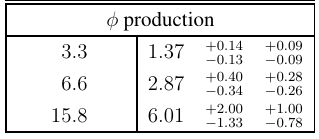

There are two different expressions for $R$. One assumes SCHC, another improves on it:

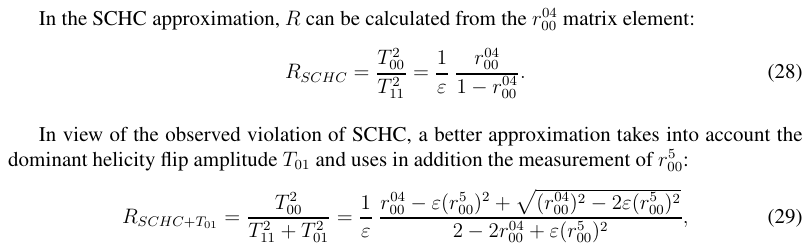

To see if discrepancy might be due to different expressions for $R$, we calculate $R$ from SDME
ourselves:

In [14]:
# SDME values from H1 table 38. Unlike DVMP cross-sections, this includes "tag" samples
# but we don't have anything else to work with:

phi_sdme_3_3 = {'r04_00': [0.581, 0.023, 0.015],
                'r5_00': [0.053, 0.034, 0.033]}

phi_sdme_6_6 = {'r04_00': [0.746, 0.024, 0.017],
                'r5_00': [0.08, 0.04, 0.036]}

phi_sdme_15_8 = {'r04_00': [0.864, 0.031, 0.019],
                'r5_00': [0.112, 0.055, 0.041]}

In [15]:
def twoRs(pt, phi_sdme):
    '''Calculate both versions of R.'''
    y = (pt.W**2 + pt.Q2 - g.constants.Mp2)/(pt.s - g.constants.Mp2)
    eps = (1-y)/(1-y+y**2/2)
    r4 = phi_sdme['r04_00'][0]
    r5 = phi_sdme['r5_00'][0]
    RSCHC = r4 / (1 - r4) / eps
    RT01 = (r4 - eps*(r5)**2 + np.sqrt(r4**2 - 2*eps*r5**2)) / (2 - 2*r4 + eps*r5**2) / eps
    print('Q2 = {}, R_SCHC = {}, R_SCHC_T01 = {}'.format(pt.Q2, RSCHC, RT01))

In [16]:
twoRs(g.dset[146][0], phi_sdme_3_3)

Q2 = 3.3, R_SCHC = 1.388850520214361, R_SCHC_T01 = 1.3751028804864196


In [17]:
twoRs(g.dset[146][1], phi_sdme_6_6)

Q2 = 6.6, R_SCHC = 2.9417065244990286, R_SCHC_T01 = 2.875947511477437


In [18]:
twoRs(g.dset[146][2], phi_sdme_15_8)

Q2 = 15.8, R_SCHC = 6.363138875246824, R_SCHC_T01 = 5.987501929044802


So, we reproduce H1 table 49 within percent, but even though $R_{SCHC}$ values are larger, they are not large enough to explain $\sigma_L/\sigma_T$  calculated using H1 published values on $\sigma_{L,T}$ from Table 20.

BTW, formula for $y$ used here is approximate, but correct one is in this kinematics less than percent away:

In [19]:
for pt in g.dset[146]:
    E = 27.5  # beam energy
    y = (pt.W**2 + pt.Q2 - g.constants.Mp2)/(pt.s - g.constants.Mp2)
    eps = (1-y)/(1-y+y**2/2)
    epsc = (1-y-pt.Q2/4/E**2)/(1-y+y**2/2*(1+pt.Q2/2/y**2/E**2)) # 2009.03271 Eq. (15)
    print(eps, epsc)

0.9984046696794381 0.9961041486147092
0.9984027466900082 0.9938068519823309
0.9983973791903387 0.9874292948522815


## The case of $\rho^0$

For $\rho^0$ we cannot simply compare numbers since values of $Q^2$ are different in Tables 17 and 49, but we can compare by plotting both sets together:

In [20]:
g.dset[78].df().val.values   #  \sigma_T  by H1 Table 19a

array([180.  ,  78.1 ,  23.7 ,   5.  ,   1.49,   0.27])

In [21]:
g.dset[76].df().val.values   #  \sigma_L  by H1 Table 19b

array([288.  , 165.  ,  74.7 ,  24.  ,   7.7 ,   1.76])

In [22]:
g.dset[601].df().val.values   # R by H1 Table 49a

array([1.36, 1.92, 3.65, 3.6 , 6.52])

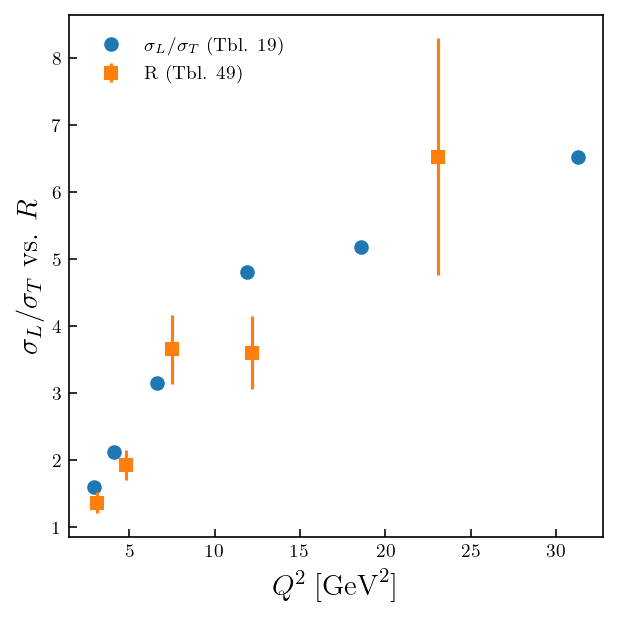

In [23]:
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
dsetL = g.dset[76].df()
dsetT = g.dset[78].df()
dsetR = g.dset[601].df()
ax.plot(dsetL.Q2.values, dsetL.val.values/dsetT.val.values, # yerr=dsetR.err.values,
            marker='o', linestyle='None', label=r'$\sigma_L/\sigma_T$ (Tbl. 19)')
ax.errorbar(dsetR.Q2.values, dsetR.val.values, yerr=dsetR.err.values,
            marker='s', linestyle='None', label=r'R (Tbl. 49)')
# ax.set_yscale('log')
ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=14)
ax.set_ylabel(r'$\sigma_L/\sigma_T$ vs. $R$', 
              fontsize=14)
ax.legend(loc='upper left')
# ax.grid()
fig.canvas.draw()

Again, there is a significant disagreement.

<span style='background:linen'> 
**Conclusion**: Lacking information about how H1 actually obtained their values, we should make some choice because it seems that using both their $\sigma_L$ and $R$ would be inconsistent.
Since we need $R$ to calculate $W$-dependent $\sigma_L$, we choose not to use data from Tables 19
and 20, but will determine/interpolate our $R$ function and calculate $\sigma_L$ ourselves from total $\sigma$. </span>

(Note that there might be some advantage in using directly $r_{00}^{04}$ instead of $R$, see Sect. 11 of ZEUS DVMP paper arXiv:0708.1478. But we will not pursue this here.)

# Determination/interpolation of $R$ function

H1 collaboration has studied L-T separation and observed for ratio $R=\sigma_L/\sigma_T$:
- clear signal of $Q^2$ dependence
- no $W$ dependence within errors
- some $t$ dependence, visible for large $Q^2$

This motivated Mueller et al. arXiv:1312.5493 to assume $W$- and $t-$ independent $R(Q^2)$ function, see below.

However, we want to use large $Q^2$ data, and it is exactly for this data that $t$-dependence starts to be visible in H1 measurements, and also H1 and ZEUS $R(Q^2)$ look significantly different there.

So, in this preliminary study, we will not use $t$-dependent cross-sections, and we will make a new $W$-dependent $R$ function, by making fit to H1 and ZEUS $W$- and $Q^2$-dependent data on $R$. 

Additional reason to avoid $t$-dependent HERA data is that $t$-dependence of $R$-ratio is measured only for $Q^2$<10 GeV$^2$, so we cannot cross-check our $R$-function.

## New fits to get $R(W, Q^2)$

### Universal R

In [24]:
for id in [601, 602, 603, 604]:
    print(id, g.dset[id].collaboration)

601 H1
602 ZEUS
603 ZEUS
604 H1


We will extend the model used by Mueller et al. with parametrized $W$-dependent part:
$$
R(W, Q^2) = \frac{Q^2}{m_\rho^2}\left(1+a\frac{Q^2}{m_\rho^2}\right)^{-p} \left(1-b\frac{Q^2}{W}\right)
$$
with a, p and b parameters to be determined by fitting to measurements of the R ratio. (Note that b is
*not* dimensionless. $W$ is not squared in the denominator to have the cleaner numerics.)

In [25]:
def modelW_rho(W_Q2, pars):
    W, Q2 = W_Q2
    a, p, b = pars
    x = Q2/0.776**2
    y = Q2/W
    return x/(1+a*x)**p * (1-b*y)

# Rdata = g.select(g.dset[601]+g.dset[602]+g.dset[603]+g.dset[604], ['Q2 > 10'])
Rdata = g.select(g.dset[603]+g.dset[604], ['Q2 > 8'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values

In [26]:
least_squares = LeastSquares(data_W_Q2, data_y, data_yerr, modelW_rho)

In [27]:
m = Minuit(least_squares, (1, 1, 1))

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.183 (χ²/ndof = 0.3)      │              Nfcn = 453              │
│ EDM = 0.000141 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     6     │    19     │            │            │         │         │       │
│ 1 │ x1   │   0.32    │   0.23    │            │            │         │         │       │
│ 2 │ x2   │    0.9    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────┐
│    │     x0     x1     x2 │
├────┼──────────────────────┤
│ x0 │    373  -4.34    9.8 │
│ x1 │  -4.34 0.0515  -0.13 │
│ x2 │    9.8  -0.13   0.71 │
└────┴──────────────────────┘

In [28]:
print(m.values)
m.covariance.tolist()

<ValueView x0=6.251397432195975 x1=0.3211706244931314 x2=0.9022081518021978>


[[372.9802979798167, -4.341668334106043, 9.752091026822168],
 [-4.341668334106043, 0.051452436510795736, -0.13166750799083524],
 [9.752091026822168, -0.13166750799083524, 0.7102237117713996]]

In [29]:
def modelW_phi(W_Q2, pars):
    W, Q2 = W_Q2
    a, p = pars
    x = Q2/1.02**2
    return x/(1+a*x)**p

Rdata = g.select(g.dset[609] + g.dset[611], ['Q2 > 6'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values

In [30]:
least_squares = LeastSquares(data_W_Q2, data_y, data_yerr, modelW_phi)

In [31]:
m = Minuit(least_squares, (1, 1))

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.748 (χ²/ndof = 0.9)      │              Nfcn = 319              │
│ EDM = 0.000137 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     6     │    28     │            │            │         │         │       │
│ 1 │ x1   │   0.27    │   0.33    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────┐
│    │    x0    x1 │
├────┼─────────────┤
│ x0 │   774 -9.16 │
│ x1 │ -9.16 0.109 │
└────┴─────────────┘

In [32]:
print(m.values)
m.covariance.tolist()

<ValueView x0=5.794868768486252 x1=0.26720102753302516>


[[774.2660285968365, -9.163763185567973],
 [-9.163763185567973, 0.10930118470470186]]

### H1 R

In [33]:
# Rdata = g.select(g.dset[601]+g.dset[602]+g.dset[603]+g.dset[604], ['Q2 > 10'])
Rdata = g.select(g.dset[601], ['Q2 > 8'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values

In [34]:
least_squares = LeastSquares(data_W_Q2, data_y, data_yerr, modelW_rho)

In [35]:
m = Minuit(least_squares, (1, 1, 1))

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.636e-05                  │              Nfcn = 194              │
│ EDM = 7.6e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     3     │    29     │            │            │         │         │       │
│ 1 │ x1   │    1.0    │    0.6    │            │            │         │         │       │
│ 2 │ x2   │  -0.1e3   │   0.8e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │      856    -0.95  -21.8e3 │
│ x1 │    -0.95    0.336  -105.20 │
│ x2 │  -21.8e3  -105.20 6.07e+05 │
└────┴────────────────────────────┘

In [36]:
print(m.values)
m.covariance.tolist()

<ValueView x0=3.4448593857655423 x1=1.0315014846337964 x2=-82.29513762415807>


[[856.4712332392247, -0.9533742942064789, -21835.31906014519],
 [-0.9533742942064789, 0.33578280444411535, -105.20123774072994],
 [-21835.31906014519, -105.20123774072994, 606922.8387879718]]

### ZEUS R

In [37]:
# Rdata = g.select(g.dset[601]+g.dset[602]+g.dset[603]+g.dset[604], ['Q2 > 10'])
Rdata = g.select(g.dset[602] + g.dset[603], ['Q2 > 8'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values

In [38]:
least_squares = LeastSquares(data_W_Q2, data_y, data_yerr, modelW_rho)

In [39]:
m = Minuit(least_squares, (1, 1, 1))

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.438 (χ²/ndof = 0.2)      │              Nfcn = 342              │
│ EDM = 1.13e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     2     │     4     │            │            │         │         │       │
│ 1 │ x1   │   0.44    │   0.26    │            │            │         │         │       │
│ 2 │ x2   │    0.3    │    1.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────┐
│    │     x0     x1     x2 │
├────┼──────────────────────┤
│ x0 │   17.2  -1.06    3.1 │
│ x1 │  -1.06 0.0662  -0.22 │
│ x2 │    3.1  -0.22   1.19 │
└────┴──────────────────────┘

In [40]:
print(m.values)
m.covariance.tolist()

<ValueView x0=2.116938695130227 x1=0.43660161212399284 x2=0.3403615255395319>


[[17.157623711807915, -1.055154593720807, 3.06553393461163],
 [-1.055154593720807, 0.06616338741413422, -0.21515323325912508],
 [3.06553393461163, -0.21515323325912508, 1.1921747441948811]]

### Final R function

We cut'n'paste these results into a compact function that can be used elsewhere:

In [41]:
def RfunW(W, Q2, meson, collaboration='HERA'):
    '''Full Q^2 and W dependent R function.'''
    if meson == 'rho0':
        if collaboration == 'H1':
            pars = np.array([3.4448593857655423, 1.0315014846337964, -82.29513762415807])
            cov = np.array([[856.4712332392247, -0.9533742942064789, -21835.31906014519],
                            [-0.9533742942064789, 0.33578280444411535, -105.20123774072994],
                            [-21835.31906014519, -105.20123774072994, 606922.8387879718]])
        elif collaboration == 'ZEUS':
            pars = np.array([2.116938695130227, 0.43660161212399284, 0.3403615255395319])
            cov = np.array([[17.157623711807915, -1.055154593720807, 3.06553393461163],
                            [-1.055154593720807, 0.06616338741413422, -0.21515323325912508],
                            [3.06553393461163, -0.21515323325912508, 1.1921747441948811]])
        else:  # HERA
        # Result of minuit fit to combined H1 and ZEUS R
            pars = np.array([6.251397432195975, 0.3211706244931314, 0.9022081518021978])
            cov = np.array([[372.9802979798167, -4.341668334106043, 9.752091026822168],
                            [-4.341668334106043, 0.051452436510795736, -0.13166750799083524],
                            [9.752091026822168, -0.13166750799083524, 0.7102237117713996]])
        y, ycov = propagate(lambda p: modelW_rho((W, Q2), p), pars, cov)
    elif meson == 'phi':
        # Result of minuit fit to combined H1 ZEUS R (not so reliable, not used atm)
        pars = np.array([5.794868768486252, 0.26720102753302516])
        cov = np.array([[774.2660285968365, -9.163763185567973],
                        [-9.163763185567973, 0.10930118470470186]])
        y, ycov = propagate(lambda p: modelW_phi((W, Q2), p), pars, cov)
        
    else:
        raise ValueError('Not implemented for {}'.format(meson))
    try:
        yerr_prop = np.diag(ycov) ** 0.5
    except ValueError:  # not an array
        yerr_prop = ycov ** 0.5
    return y, yerr_prop

In [42]:
def sigtot2sigL(dtset, collaboration='HERA'):
    '''Transform total xs dataset to longitudinal xs dataset.'''
    out = []
    for pt in g.select(dtset, criteria=['Q2 >= 4.0']):
        ptxl = pt.copy()
        y = (pt.W**2 + pt.Q2 - g.constants.Mp2)/(pt.s - g.constants.Mp2)
        eps = (1-y)/(1-y+y**2/2)
        R, delR = RfunW(ptxl.W, pt.Q2, ptxl.out1particle, collaboration)
        ptxl.val = pt.val/(eps + 1./R)
        errsig = pt.err / (eps+1./R)
        errR = pt.val * delR / (1.+eps*R)**2
        ptxl.err = np.sqrt( errsig**2 + errR**2)
        ptxl.in1polarization = '1'
        ptxl.in1polarizationvector = 'L'
        ptxl.y1namelong = 'differential cross section XL'
        out.append(ptxl)
    return g.DataSet(out)

## First checks

Some plots to check this, rho first

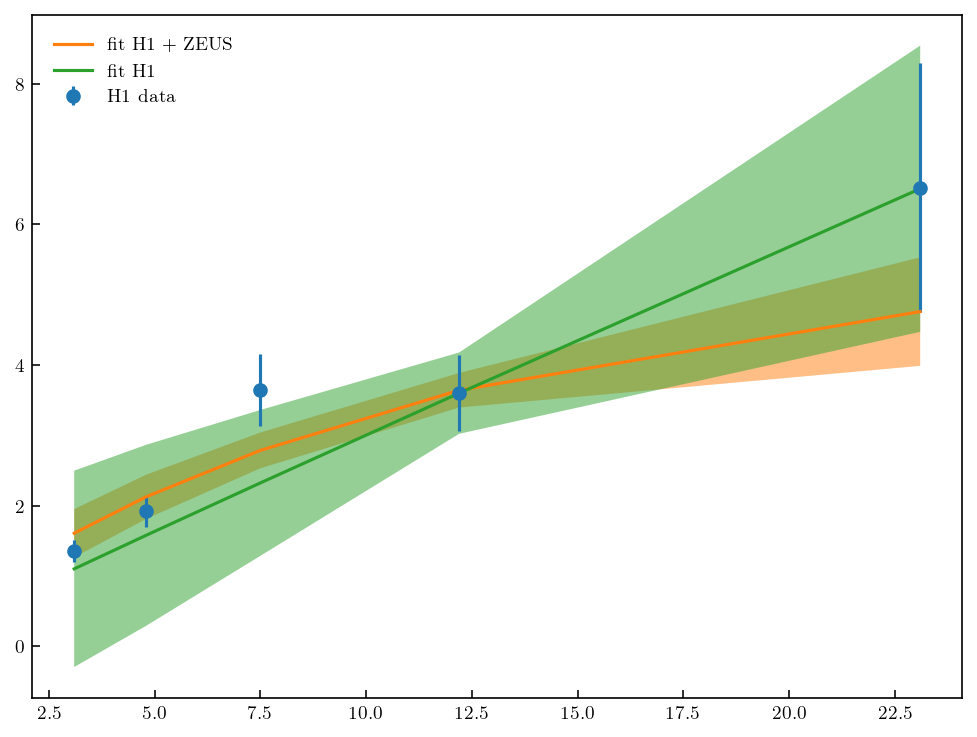

In [43]:
Rdata = g.select(g.dset[601], ['Q2 > 1'])  # H1
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values
# run error propagation
y, yerr = RfunW(data_W, data_Q2, 'rho0')
yH1, yH1err = RfunW(data_W, data_Q2, 'rho0', 'H1')

# draw data and fitted line
plt.errorbar(data_Q2, data_y, data_yerr, fmt="o", label="H1 data")
plt.plot(data_Q2, y, label="fit H1 + ZEUS")
plt.fill_between(data_Q2, y - yerr, 
                 y + yerr, facecolor="C1", alpha=0.5)
plt.plot(data_Q2, yH1, label="fit H1")
plt.fill_between(data_Q2, yH1 - yH1err, 
                 yH1 + yH1err, facecolor="C2", alpha=0.5)
plt.legend(loc='upper left');

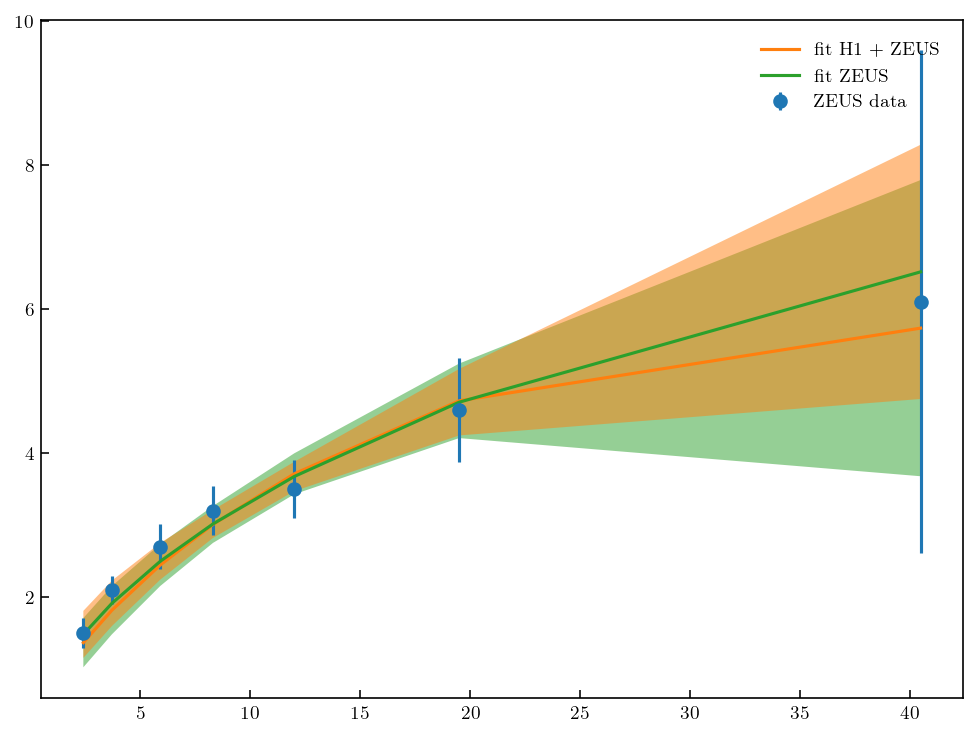

In [44]:
Rdata = g.select(g.dset[602], ['Q2 > 1'])  # ZEUS
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values
# run error propagation
# y, ycov = propagate(lambda p: modelW_rho(data_W_Q2, p), m.values, m.covariance)
# yerr_prop = np.diag(ycov) ** 0.5
y, yerr = RfunW(data_W, data_Q2, 'rho0')
yZ, yerrZ = RfunW(data_W, data_Q2, 'rho0', 'ZEUS')

# draw data and fitted line
plt.errorbar(data_Q2, data_y, data_yerr, fmt="o", label="ZEUS data")
plt.plot(data_Q2, y, label="fit H1 + ZEUS")
plt.fill_between(data_Q2, y - yerr, 
                 y + yerr, facecolor="C2", alpha=0.5)
plt.plot(data_Q2, yZ, label="fit ZEUS")
plt.fill_between(data_Q2, yZ - yerrZ, 
                 yZ + yerrZ, facecolor="C1", alpha=0.5)

plt.legend(loc=1);

W dependence:

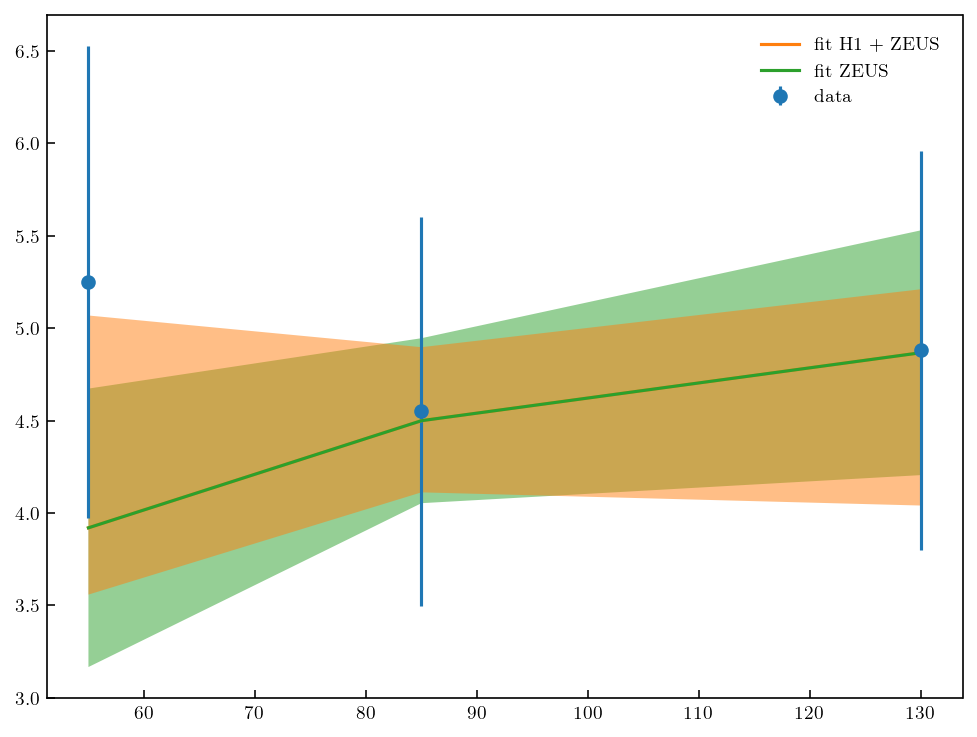

In [45]:
Rdata = g.select(g.dset[603], ['Q2 > 15'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values
# run error propagation
# y, ycov = propagate(lambda p: modelW_rho(data_W_Q2, p), m.values, m.covariance)
# yerr_prop = np.diag(ycov) ** 0.5
y, yerr = RfunW(data_W, data_Q2, 'rho0')
yZ, yerrZ = RfunW(data_W, data_Q2, 'rho0', 'ZEUS')
# draw data and fitted line
plt.errorbar(data_W, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_W, y, label="fit H1 + ZEUS")
plt.fill_between(data_W, y - yerr, 
                 y + yerr, facecolor="C2", alpha=0.5)
plt.plot(data_W, y, label="fit ZEUS")
plt.fill_between(data_W, yZ - yerrZ, 
                 yZ + yerrZ, facecolor="C1", alpha=0.5)
plt.legend(loc=1, framealpha=0.5)

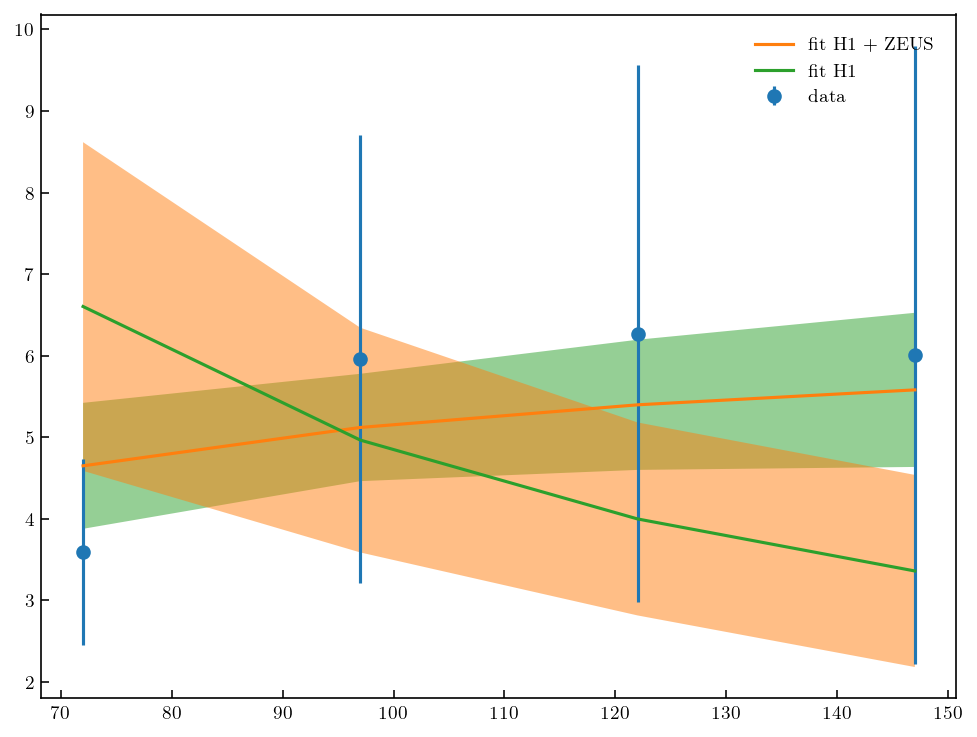

In [46]:
Rdata = g.select(g.dset[604], ['Q2 > 20'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values
# run error propagation
# y, ycov = propagate(lambda p: modelW_rho(data_W_Q2, p), m.values, m.covariance)
# yerr_prop = np.diag(ycov) ** 0.5
y, yerr = RfunW(data_W, data_Q2, 'rho0')
yH, yerrH = RfunW(data_W, data_Q2, 'rho0', 'H1')
# draw data and fitted line
plt.errorbar(data_W, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_W, y, label="fit H1 + ZEUS")
plt.fill_between(data_W, y - yerr, 
                 y + yerr, facecolor="C2", alpha=0.5)
plt.plot(data_W, yH, label="fit H1")
plt.fill_between(data_W, yH - yerrH, 
                 yH + yerrH, facecolor="C1", alpha=0.5)
plt.legend(framealpha=0.5)

And phi. We will not need this, but let's have it here:

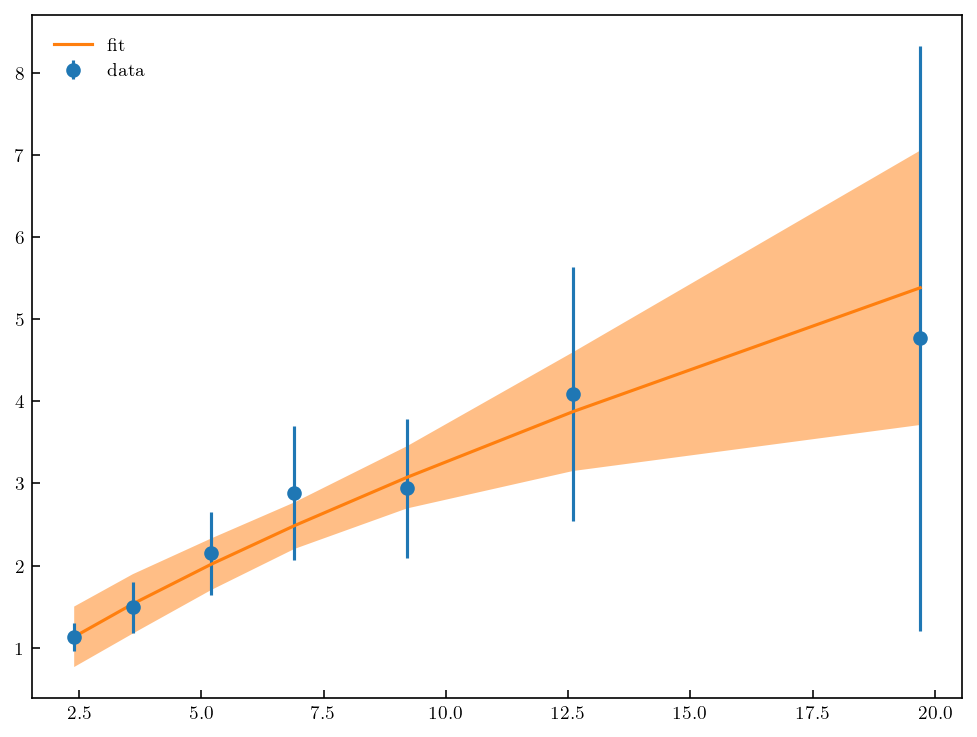

In [47]:
Rdata = g.select(g.dset[610], ['Q2 > 1'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values
# run error propagation
# y, ycov = propagate(lambda p: modelW_phi(data_W_Q2, p), m.values, m.covariance)
# yerr_prop = np.diag(ycov) ** 0.5
y, yerr_prop = RfunW(data_W, data_Q2, 'phi')

# draw data and fitted line
plt.errorbar(data_Q2, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_Q2, y, label="fit")
plt.fill_between(data_Q2, y - yerr_prop, 
                 y + yerr_prop, facecolor="C1", alpha=0.5)

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_Q2) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(loc=2);

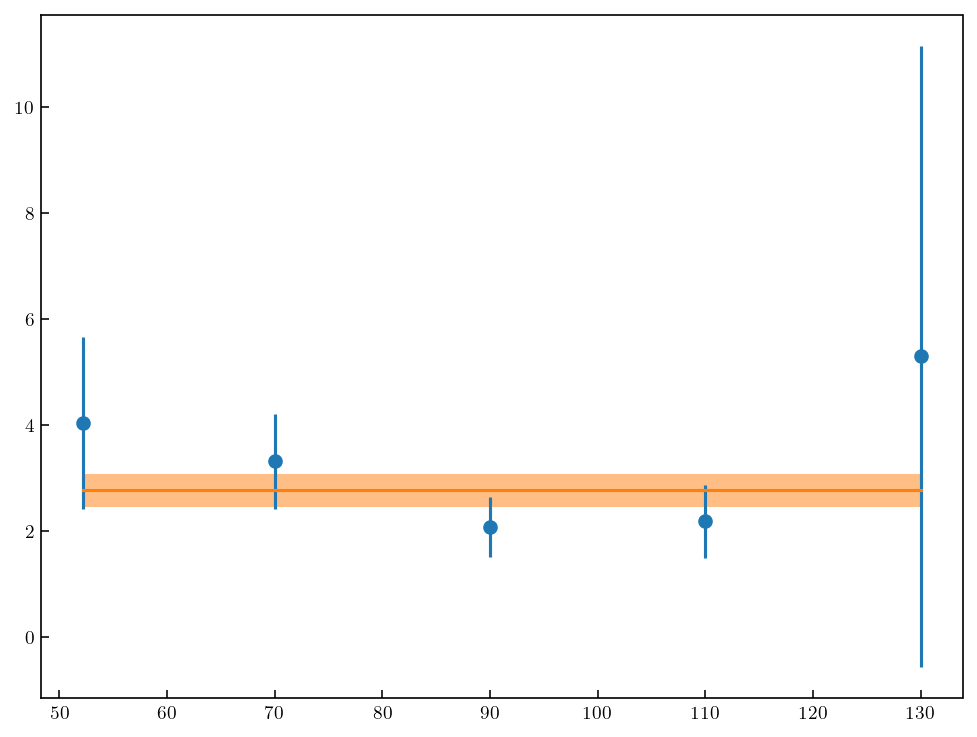

In [48]:
Rdata = g.select(g.dset[611], ['Q2 > 6'])
data_W = Rdata.df().W.values
data_Q2 = Rdata.df().Q2.values
data_W_Q2 = (data_W, data_Q2)
data_y = Rdata.df().val.values
data_yerr = Rdata.df().err.values
# run error propagation
# y, ycov = propagate(lambda p: modelW_rho(data_W_Q2, p), m.values, m.covariance)
# yerr_prop = np.diag(ycov) ** 0.5
y, yerr_prop = RfunW(data_W, data_Q2, 'phi')

# draw data and fitted line
plt.errorbar(data_W, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_W, y, label="fit")
plt.fill_between(data_W, y - yerr_prop, 
                 y + yerr_prop, facecolor="C1", alpha=0.5)

## Other R functions

We define some other R functions, by Mueller et al., from T. Lautenschlager's PhD
thesis, and some R functions we used in the development of the above one and we
keep it for historical purposes.

In [49]:
def Rfun1(Q2, meson, ref='KKT', W = 75):
    if meson == 'rho0':
        mV = 0.776
        if ref == 'PhD':
            # From Tobias PhD
            p = 0.336; delp = 0.057
            a = 10.453; dela = 10.070
        elif ref == 'KKT':
            # Our fit, but with Tobias uncerts
            p = 0.29006965; delp = 0.057
            a = 12.2026443; dela = 10.070
            if W > 85:
                # For ZEUS special treatment here
                # uncerts by eyball matching to Tobias
                p = 0.55307169; delp = 0.08
                a = 1.02015374; dela = 0.8
        elif ref == 'KK':
            # Our fit
            p = 0.29006965; delp = 0.115
            a = 12.2026443; dela = 27.8
        else:
            # From arXiv:1312.5493
            p = 0.482; delp = 0.0481
            a = 1.845; dela = 0.554
    elif meson == 'phi':
        mV = 1.02
        if ref == 'PhD':
            # From Tobias PhD
            p = 0.160; delp = 0.027
            a = 57.755; dela = 34.986
        else:
            # From arXiv:1312.5493
            p = 0.191; delp = 0.035
            a = 22.181; dela = 13.45
    else:
        raise ValueError('Not implemented for {}'.format(meson))
    x = Q2/mV**2
    R = x/(1+a*x)**p
    delR = np.sqrt( p**2 * x**2 * R**2 * dela**2 / (1.+a*x)**2 +
	   np.log(1.+a*x)**2 * R**2 * delp**2) 
    return (R, delR)

Taking covariances into consideration gives some weird results for $\rho^0$ - to be checked at some point. But it seems to be beter for $\phi$ so we take that.

In [50]:
def Rfun2(Q2, meson, ref='', W=75):
    if meson == 'rho0':
        mV = 0.776   
        # Result of scipy curve_fit to H1 R dset[606]
        # absolute_sigma = False
        pars = np.array([52.37748306,  0.23265702])
        cov = np.array([[ 2.66150169e+04, -1.87911660e+01],
                     [-1.87911660e+01,  1.33875219e-02]])
        # absolute_sigma = True
        pars = np.array([52.37748306,  0.23265702])
        cov = np.array([[ 2.17791914e+04, -1.53768981e+01],
                        [-1.53768981e+01,  1.09550711e-02]])
    elif meson == 'phi':
        mV = 1.02
        # absolute_sigma = False
        pars = np.array([36.10818878,  0.16788817])
        cov = np.array([[ 3.33761237e+03, -3.02947604e+00],
                        [-3.02947604e+00,  2.77791136e-03]])
        # absolute_sigma = True
        pars = np.array([36.10818878,  0.16788817])
        cov = np.array([[ 2.04464966e+04, -1.85588273e+01],
                        [-1.85588273e+01,  1.70177207e-02]])
    else:
        raise ValueError('Not implemented for {}'.format(meson))
    a, p = pars
    x = Q2 / mV**2
    R = x / (1+a*x)**p
    # -dR/da  and -dR/dp
    dRda = p/((a+x)/x)**(p+1)
    dRdp = x*np.log((a+x)/x)/((a+x)/x)**p
    diffs = np.array([dRda, dRdp])
    # total variance including correlations
    variance = np.einsum('i...,ij,j...', diffs, cov, diffs)
    delR = np.sqrt(variance)
    return R, delR

In [51]:
def Rfun(Q2, meson, ref='KKT', W=75):
    if meson == 'rho0':
        return Rfun1(Q2, meson, ref, W)
    elif meson == 'phi':
        return Rfun2(Q2, meson, ref, W)
    else:
        raise ValueError('Not implemented for {}'.format(meson))

In [52]:
def sigtot2sigL(dtset, ref='WQ2', collaboration='HERA'):
    '''Transform total xs dataset to longitudinal xs dataset.'''
    out = []
    for pt in g.select(dtset, criteria=['Q2 >= 4.0']):
        ptxl = pt.copy()
        y = (pt.W**2 + pt.Q2 - g.constants.Mp2)/(pt.s - g.constants.Mp2)
        eps = (1-y)/(1-y+y**2/2)
        if ref == 'WQ2':
            R, delR = RfunW(ptxl.W, pt.Q2, ptxl.out1particle, collaboration)
        else:
            R, delR = Rfun(pt.Q2, ptxl.out1particle, ref, ptxl.W)
        ptxl.val = pt.val/(eps + 1./R)
        errsig = pt.err / (eps+1./R)
        errR = pt.val * delR / (1.+eps*R)**2
        ptxl.err = np.sqrt( errsig**2 + errR**2)
        ptxl.in1polarization = '1'
        ptxl.in1polarizationvector = 'L'
        ptxl.y1namelong = 'differential cross section XL'
        out.append(ptxl)
    return g.DataSet(out)

## Checking against published $R$ data - $Q^2$ dependence

/tmp/ipykernel_18759/885073854.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


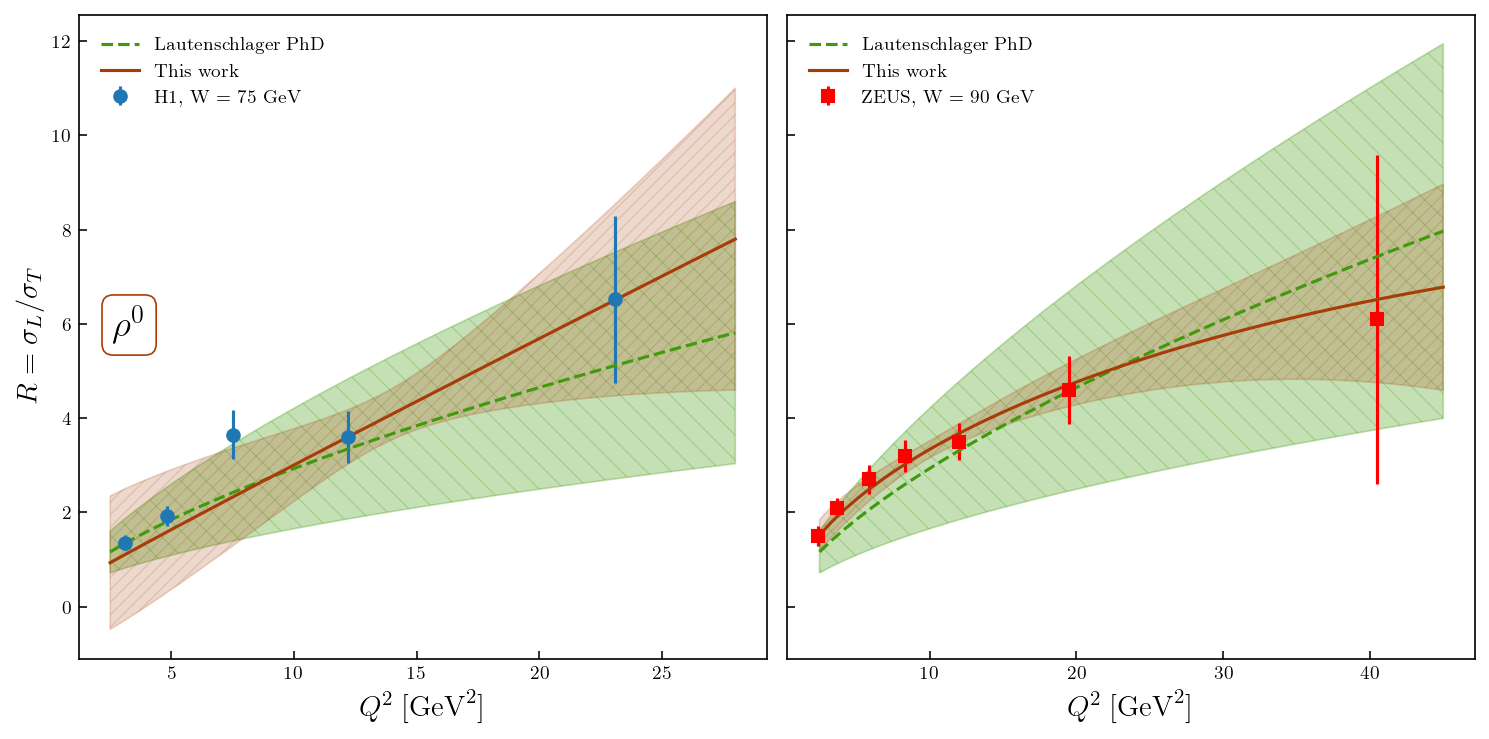

In [53]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5], sharey=True)
ax = axs[0]
set75 = g.dset[601].df()  # H1
Q2s = np.linspace(2.5, 28)
Ws = np.array(len(Q2s)*[75.])
RDM, errRDM = RfunW(Ws, Q2s, 'rho0', 'H1')
RDMrho, errRDMrho = Rfun1(Q2s, 'rho0', 'PhD')
ax.errorbar(set75.Q2.values, set75.val.values, yerr=set75.err.values,
            marker='o', linestyle='None', label='H1, W = 75 GeV')
ax.plot(Q2s, RDMrho, color='xkcd:grass green', ls='--', label='Lautenschlager PhD')
ax.fill_between(Q2s, RDMrho - errRDMrho, RDMrho + errRDMrho, hatch='\\\\',
                 color='xkcd:grass green', alpha=0.3)
ax.plot(Q2s, RDM, color='xkcd:rust', label='This work')
ax.fill_between(Q2s, RDM - errRDM, RDM + errRDM, hatch='////',
                 color='xkcd:rust', alpha=0.2)
ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=14)
ax.set_ylabel('$R = \sigma_L/\sigma_T$', fontsize=14)
ax.text(0.05, 0.5, r"$\rho^0$", fontsize=18, transform=ax.transAxes,
            bbox=dict(boxstyle="round", ec="xkcd:rust", fc="white"))
ax.legend(loc='upper left')
# second panel
ax = axs[1]
Q2s = np.linspace(2.5, 45)
Ws = np.array(len(Q2s)*[90.])
RDM, errRDM = RfunW(Ws, Q2s, 'rho0', 'ZEUS')
RDM2, errRDM2 = Rfun1(Q2s, 'rho0', ref='PhD')
set90 = g.dset[602].df()  # ZEUS
ax.errorbar(set90.Q2.values, set90.val.values, yerr=set90.err.values,
            marker='s', linestyle='None', color='red', label='ZEUS, W = 90 GeV')
ax.plot(Q2s, RDM2, color='xkcd:grass green', ls='--', label='Lautenschlager PhD')
ax.fill_between(Q2s, RDM2 - errRDM2, RDM2 + errRDM2, hatch='\\\\',
                 color='xkcd:grass green', alpha=0.3)
ax.plot(Q2s, RDM, color='xkcd:rust', label='This work')
ax.fill_between(Q2s, RDM - errRDM, RDM + errRDM, hatch='////',
                 color='xkcd:rust', alpha=0.2)
ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=14)
ax.legend(loc='upper left')
fig.tight_layout()
fig.canvas.draw()

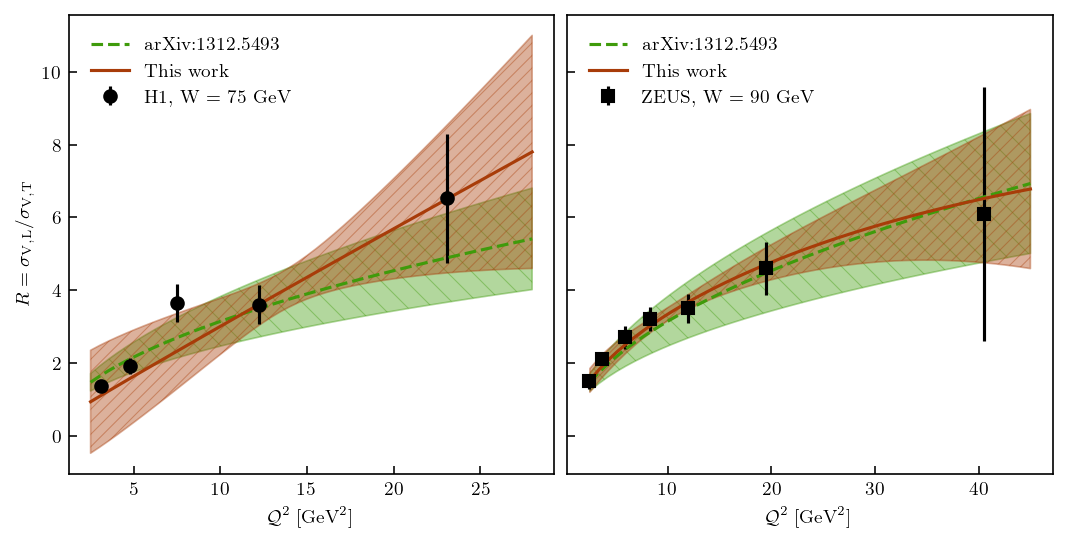

In [54]:
fig, axs = plt.subplots(1, 2, figsize=[7, 3.5], sharey=True)
ax = axs[0]
set75 = g.dset[601].df()  # H1
Q2s = np.linspace(2.5, 28)
Ws = np.array(len(Q2s)*[75.])
RDM, errRDM = RfunW(Ws, Q2s, 'rho0', 'H1')
RDMrho, errRDMrho = Rfun1(Q2s, 'rho0', 'arXiv')
ax.errorbar(set75.Q2.values, set75.val.values, yerr=set75.err.values,
            marker='o', linestyle='None', color='black', label='H1, W = 75 GeV')
ax.plot(Q2s, RDMrho, color='xkcd:grass green', ls='--', label='arXiv:1312.5493')
ax.fill_between(Q2s, RDMrho - errRDMrho, RDMrho + errRDMrho, hatch='\\\\',
                 color='xkcd:grass green', alpha=0.4)
ax.plot(Q2s, RDM, color='xkcd:rust', label='This work')
ax.fill_between(Q2s, RDM - errRDM, RDM + errRDM, hatch='////',
                 color='xkcd:rust', alpha=0.4)
ax.set_xlabel(r"$\mathcal{Q}^2\;[\mathrm{GeV}^2]$")
ax.set_ylabel(r"$R = \sigma_{\rm V,L}/\sigma_{\rm V,T}$")
# ax.text(0.05, 0.5, r"$\rho^0$", transform=ax.transAxes)
ax.legend(loc='upper left')
# second panel
ax = axs[1]
Q2s = np.linspace(2.5, 45)
Ws = np.array(len(Q2s)*[90.])
RDM, errRDM = RfunW(Ws, Q2s, 'rho0', 'ZEUS')
RDM2, errRDM2 = Rfun1(Q2s, 'rho0', ref='arXiv')
set90 = g.dset[602].df()  # ZEUS
ax.errorbar(set90.Q2.values, set90.val.values, yerr=set90.err.values,
            marker='s', linestyle='None', color='black', label='ZEUS, W = 90 GeV')
ax.plot(Q2s, RDM2, color='xkcd:grass green', ls='--', label='arXiv:1312.5493')
ax.fill_between(Q2s, RDM2 - errRDM2, RDM2 + errRDM2, hatch='\\\\',
                 color='xkcd:grass green', alpha=0.4)
ax.plot(Q2s, RDM, color='xkcd:rust', label='This work')
ax.fill_between(Q2s, RDM - errRDM, RDM + errRDM, hatch='////',
                 color='xkcd:rust', alpha=0.4)
ax.set_xlabel('$\mathcal{Q}^2\;[\mathrm{GeV}^2]$')
ax.legend(loc='upper left')
# fig.tight_layout()
fig.canvas.draw()

In [55]:
fig.savefig('{}/Rfunction.pdf'.format(FIGDIR))

In [56]:
Q2s = np.linspace(2., 30)
Ws = np.array(len(Q2s)*[75.])
#RDM, errRDM = Rfun(Q2s, 'phi')
RDM, errRDM = RfunW(Ws, Q2s, 'phi')
RDM2, errRDM2 = Rfun1(Q2s, 'phi', ref='PhD')

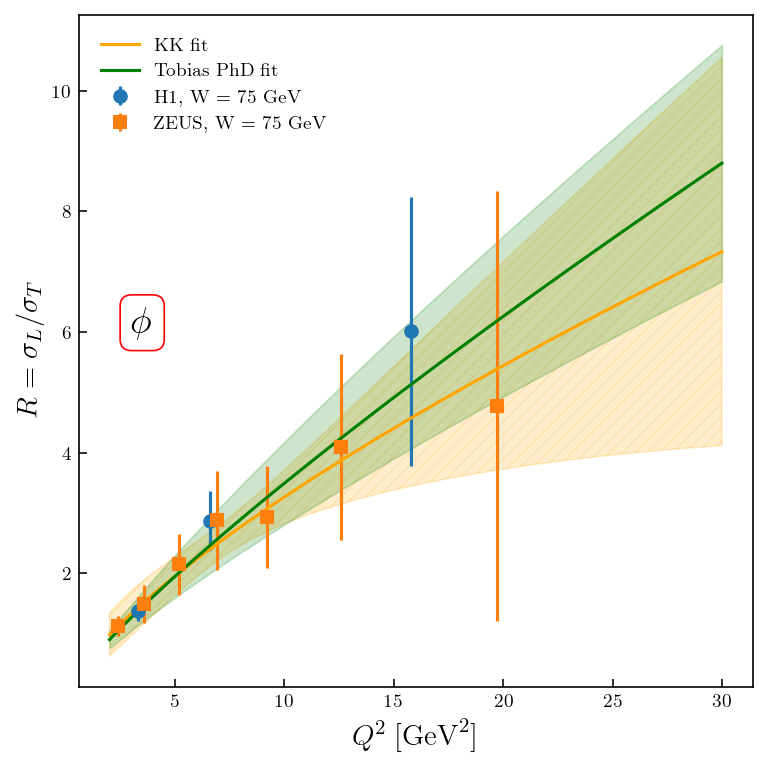

In [57]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
setH1 = g.dset[609].df()  # H1
setZE = g.dset[610].df()  # ZEUS
ax.errorbar(setH1.Q2.values, setH1.val.values, yerr=setH1.err.values,
            marker='o', linestyle='None', label='H1, W = 75 GeV')
ax.errorbar(setZE.Q2.values, setZE.val.values, yerr=setZE.err.values,
            marker='s', linestyle='None', label='ZEUS, W = 75 GeV')
ax.plot(Q2s, RDM, color='orange', label='KK fit')
ax.fill_between(Q2s, RDM - errRDM, RDM + errRDM, hatch='////',
                 color='orange', alpha=0.2)
ax.plot(Q2s, RDM2, color='green', label='Tobias PhD fit')
ax.fill_between(Q2s, RDM2 - errRDM2, RDM2 + errRDM2,# hatch='\\\\',
                 color='green', alpha=0.2)
ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=14)
ax.set_ylabel('$R = \sigma_L/\sigma_T$', fontsize=14)
#ax.text(50, 7, 'H1 Tbl. 49', fontsize=12)
ax.text(3, 6, r"$\phi$", fontsize=18,
            bbox=dict(boxstyle="round", ec="red", fc="white"))
ax.legend(loc='upper left')
fig.canvas.draw()

This function is then used to extract $\sigma_L$ from H1 and ZEUS data. To get $\sigma_L$ from data
binned in $W$ or $t$, one relies on the assumption of $W$ and $t$ independence of $R$, which is supported by HERA collider data, but only within very large uncertainties. Looking at more precise COMPASS measurements at lower energies (Fig. 11b in https://arxiv.org/abs/2009.03271 ), there is a clear $t$-dependence. 
There is also a hint of $t$-dependence  in Table. 51 of H1 paper, for large $Q^2$.

In the light of this, we consider the question unresolved and will for this initial study remove $t$-dependent HERA collider datasets from fits.

## Checking against published $\sigma_L$

Let's do a sanity check and calculate $\sigma_L$ from total $\sigma$
from Table 14 of H1 paper using this $R(Q^2)$, and compare to $\sigma_L$ extracted by H1 collaboration in Table 19b.

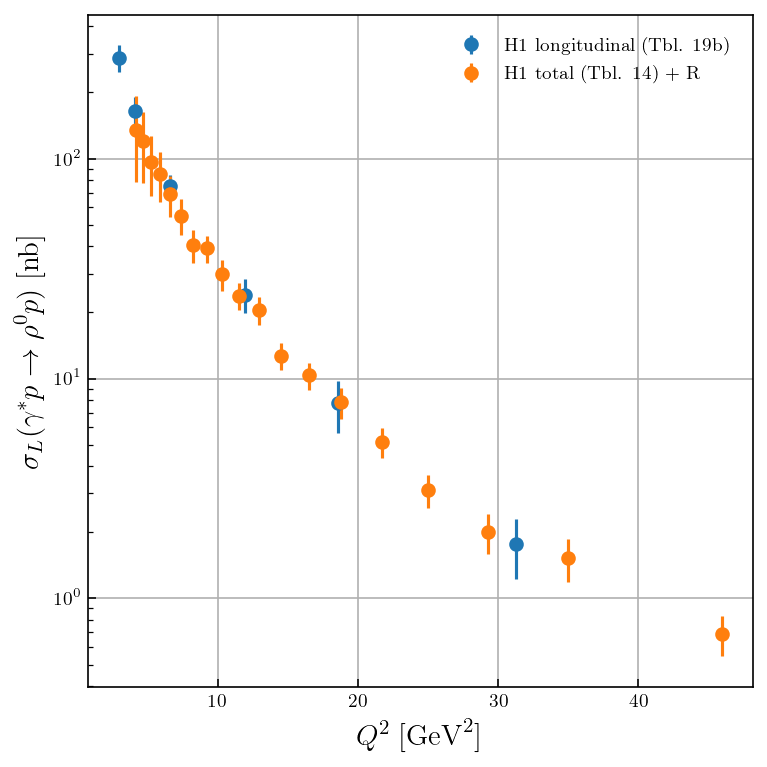

In [58]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
dset = g.dset[76].df()  # \sigma_L by H1
dset2 = sigtot2sigL(g.dset[606], collaboration='H1').df()
ax.errorbar(dset.Q2.values, dset.val.values, yerr=dset.err.values,
            marker='o', linestyle='None', label='H1 longitudinal (Tbl. 19b)')
ax.errorbar(dset2.Q2.values, dset2.val.values, yerr=dset2.err.values,
            marker='o', linestyle='None', label='H1 total (Tbl. 14) + R')
ax.set_yscale('log')
ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=14)
ax.set_ylabel(r'$\sigma_L (\gamma^* p \to \rho^0 p)\;[\mathrm{nb}]$', 
              fontsize=14)
ax.legend(loc='upper right')
ax.grid()
fig.canvas.draw()

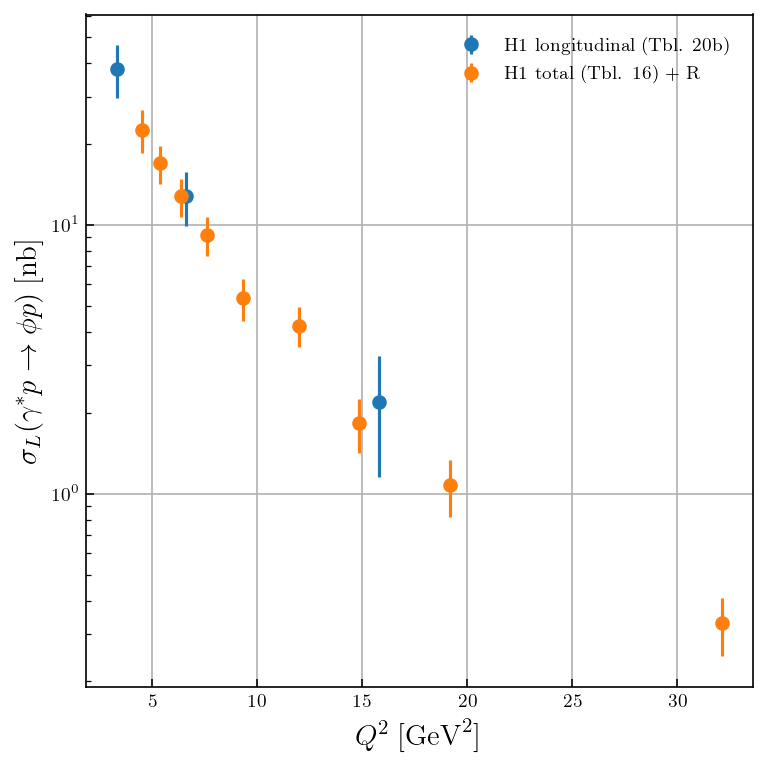

In [59]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
dset = g.dset[146].df()  # \sigma_L by H1
dset2 = sigtot2sigL(g.dset[77]).df()
ax.errorbar(dset.Q2.values, dset.val.values, yerr=dset.err.values,
            marker='o', linestyle='None', label='H1 longitudinal (Tbl. 20b)')
ax.errorbar(dset2.Q2.values, dset2.val.values, yerr=dset2.err.values,
            marker='o', linestyle='None', label='H1 total (Tbl. 16) + R')
ax.set_yscale('log')
ax.set_xlabel('$Q^2\;[\mathrm{GeV}^2]$', fontsize=14)
ax.set_ylabel(r'$\sigma_L (\gamma^* p \to \phi p)\;[\mathrm{nb}]$', 
              fontsize=14)
ax.legend(loc='upper right')
ax.grid()
fig.canvas.draw()

We note that we get smaller uncertainties on $\sigma_L$ than H1 people. Mean values agree within errors.

## Checking against published $R$ data - $t$ dependence

Checks in this and in the next section are not checks of the finally used $R$ function, but
of the development ones. We keep it for historical purposes.

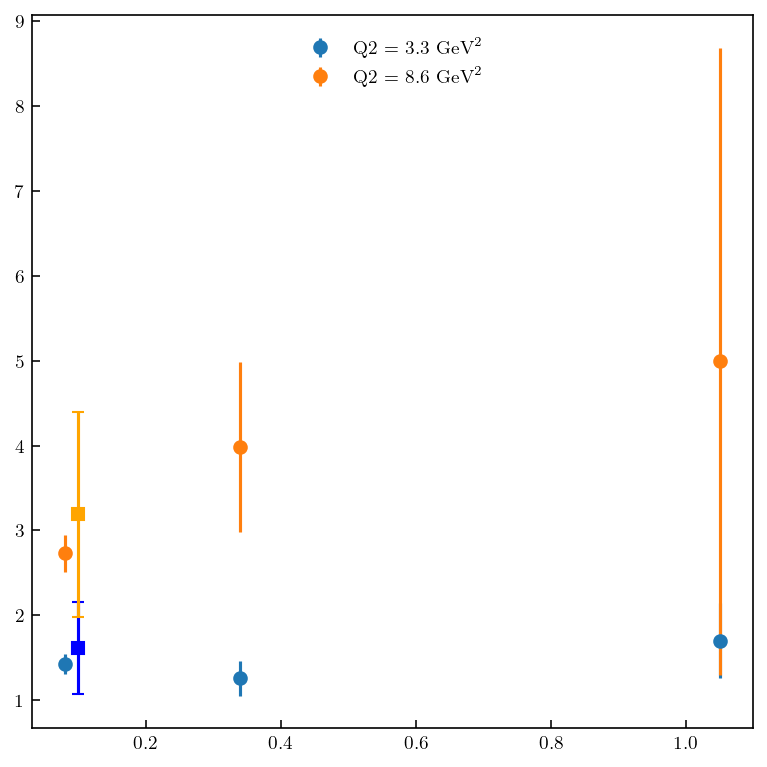

In [60]:
RRRfun = lambda x: Rfun(x, 'rho0')
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
dset3 = g.dset[605][:3].df()
dset8 = g.dset[605][3:].df()
ax.errorbar(dset3.tm.values, dset3.val.values, yerr=dset3.err.values,
            marker='o', linestyle='None', label='Q2 = 3.3 GeV$^2$')
RDM, errRDM = RRRfun(3.3)
ax.errorbar(0.1, RDM, errRDM, marker='s',
             color='blue', linestyle='None', capsize=3)
ax.errorbar(dset8.tm.values, dset8.val.values, yerr=dset8.err.values,
            marker='o', linestyle='None', label='Q2 = 8.6 GeV$^2$')
RDM, errRDM = RRRfun(8.6)
ax.errorbar(0.1, RDM, errRDM, marker='s',
             color='orange', linestyle='None', capsize=3)
# ax.text(30, 6, "H1 Tbl. 51\nGepard ID=605", 
#         bbox=dict(boxstyle="round", ec="red", fc="white"))
ax.legend(loc='upper center')
fig.canvas.draw()

## Checking against published $R$ data - $W$ dependence

Let's first see if (almost) $W$-independent $R$-ratio we intend to use is consistent with $R$-ratio measured by H1 and ZEUS:

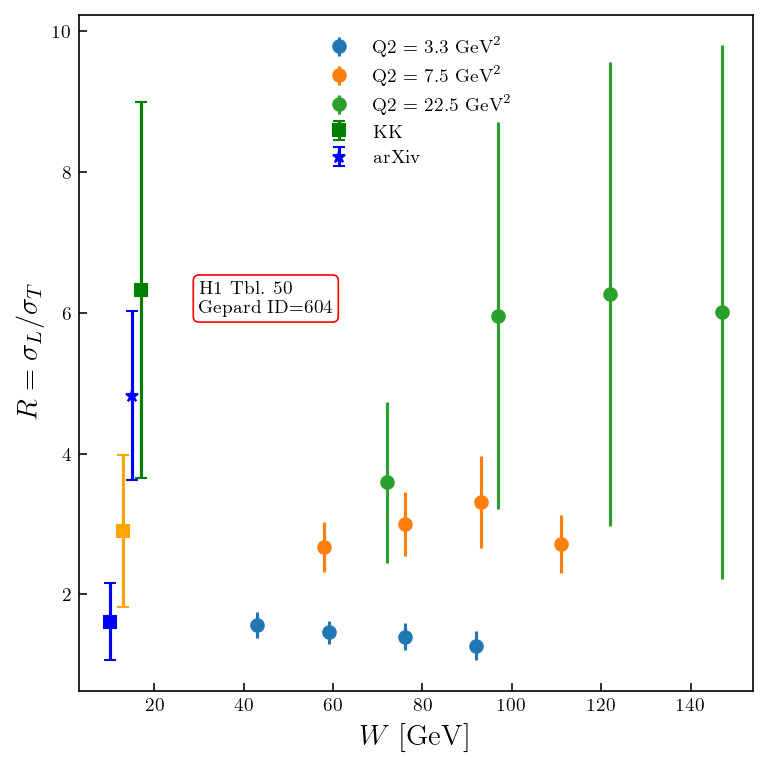

In [61]:
RRRfun = lambda x: Rfun(x, 'rho0')
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
set3 = g.dset[604][:4].df()
set7 = g.dset[604][4:8].df()
set22 = g.dset[604][8:].df()
ax.errorbar(set3.W.values, set3.val.values, yerr=set3.err.values,
            marker='o', linestyle='None', label='Q2 = 3.3 GeV$^2$')
RDM, errRDM = RRRfun(3.3)
ax.errorbar(10, RDM, errRDM, marker='s',
             color='blue', linestyle='None', capsize=3)
ax.errorbar(set7.W.values, set7.val.values, yerr=set7.err.values,
            marker='o', linestyle='None', label='Q2 = 7.5 GeV$^2$')
RDM, errRDM = RRRfun(7.5)
ax.errorbar(13, RDM, errRDM, marker='s',
             color='orange', linestyle='None', capsize=3)
ax.errorbar(set22.W.values, set22.val.values, yerr=set22.err.values,
            marker='o', linestyle='None', label='Q2 = 22.5 GeV$^2$')
RDM, errRDM = RRRfun(22.5)
ax.errorbar(17, RDM, errRDM, marker='s', label ='KK',
             color='green', linestyle='None', capsize=3)
RDM, errRDM = Rfun1(22.5, 'rho0', ref='arXiv')
ax.errorbar(15, RDM, errRDM, marker='*', label ='arXiv',
             color='blue', linestyle='None', capsize=3)
ax.set_xlabel('$W\;[\mathrm{GeV}]$', fontsize=14)
ax.set_ylabel('$R = \sigma_L/\sigma_T$', fontsize=14)
ax.text(30, 6, "H1 Tbl. 50\nGepard ID=604", 
        bbox=dict(boxstyle="round", ec="red", fc="white"))
ax.legend(loc='upper center')
fig.canvas.draw()

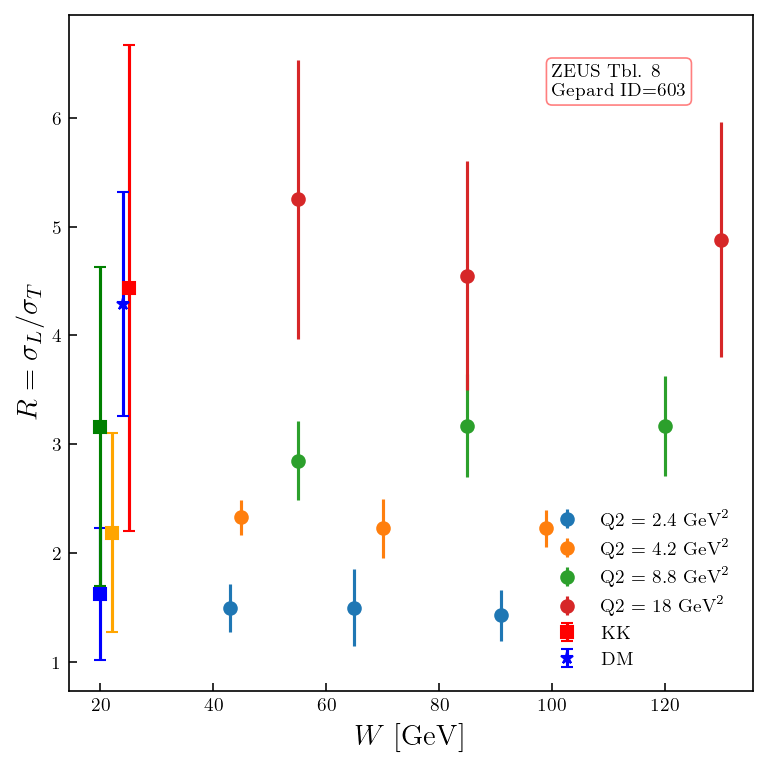

In [62]:
# We take W=90 to trigger ZEUS fit even if W is not always 90 GeV
RRRfun = lambda x: Rfun(x, 'rho0', W=90)
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
set2 = g.dset[603][:3].df()
set4 = g.dset[603][3:6].df()
set8 = g.dset[603][6:9].df()
set18 = g.dset[603][9:].df()
ax.errorbar(set2.W.values, set2.val.values, yerr=set2.err.values,
            marker='o', linestyle='None', label='Q2 = 2.4 GeV$^2$')
RDM, errRDM = RRRfun(2.4)
ax.errorbar(20, RDM, errRDM, marker='s',
             color='blue', linestyle='None', capsize=3)
ax.errorbar(set4.W.values, set4.val.values, yerr=set4.err.values,
            marker='o', linestyle='None', label='Q2 = 4.2 GeV$^2$')
RDM, errRDM = RRRfun(4.2)
ax.errorbar(22, RDM, errRDM, marker='s',
             color='orange', linestyle='None', capsize=3)
ax.errorbar(set8.W.values, set8.val.values, yerr=set8.err.values,
            marker='o', linestyle='None', label='Q2 = 8.8 GeV$^2$')
RDM, errRDM = RRRfun(8.8)
ax.errorbar(20, RDM, errRDM, marker='s',
             color='green', linestyle='None', capsize=3)
ax.errorbar(set18.W.values, set18.val.values, yerr=set18.err.values,
            marker='o', linestyle='None', label='Q2 = 18 GeV$^2$')
RDM, errRDM = RRRfun(18)
ax.errorbar(25, RDM, errRDM, marker='s', label ='KK',
             color='red', linestyle='None', capsize=3)
RDM, errRDM = Rfun1(18, 'rho0', ref='arXiv')
ax.errorbar(24, RDM, errRDM, marker='*', label ='DM',
             color='blue', linestyle='None', capsize=3)
ax.set_xlabel('$W\;[\mathrm{GeV}]$', fontsize=14)
ax.set_ylabel('$R = \sigma_L/\sigma_T$', fontsize=14)
ax.text(100, 6.2, "ZEUS Tbl. 8\nGepard ID=603", 
        bbox=dict(boxstyle="round", ec="red", fc="white",
                 alpha=0.5))
ax.legend(loc='lower right')
fig.canvas.draw()

So, `KK` choice seems somewhat better, as expected, for larger $Q^2$ which are the only ones that are going to be used in fits. Here our uncertainties are a bit larger than ZEUS ones.

**Conclusion**:  $R(Q^2)$ is a bit of a mess, but at this stage it was good enough. Finally, we end up with $R(W, Q^2)$ defined above that is consistent with all measurements, and should maybe be used with switch `collaboration` depending on whether H1 of ZEUS cross section data is used and L/T separated.

# $\sigma$ vs. $\sigma_L$  $W$-dependence

/tmp/ipykernel_18759/3430827689.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


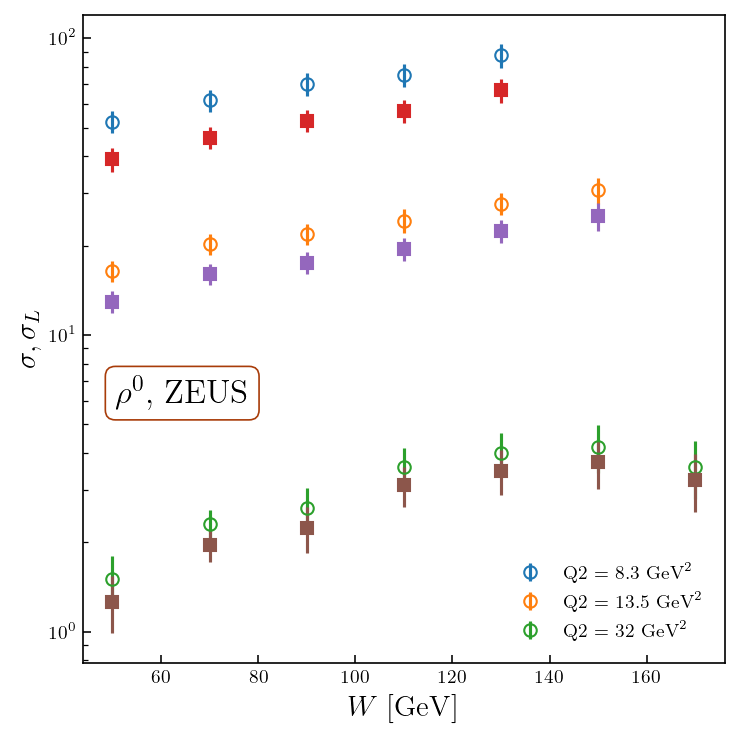

In [63]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5], sharey=True)
set8 = g.dset[608][15:20].df()
set13 = g.dset[608][20:26].df()
set32 = g.dset[608][26:].df()
ax.errorbar(set8.W.values, set8.val.values, yerr=set8.err.values,
            marker='o', mfc='None', linestyle='None', label='Q2 = 8.3 GeV$^2$')
ax.errorbar(set13.W.values, set13.val.values, yerr=set13.err.values,
            marker='o', mfc='None', linestyle='None', label='Q2 = 13.5 GeV$^2$')
ax.errorbar(set32.W.values, set32.val.values, yerr=set32.err.values,
            marker='o', mfc='None', linestyle='None', label='Q2 = 32 GeV$^2$')
ax.set_ylabel('$\sigma, \sigma_L$', fontsize=14)
ax.legend(loc=4)
set8L = sigtot2sigL(g.dset[608][15:20], collaboration='ZEUS').df()
set13L = sigtot2sigL(g.dset[608][20:26], collaboration='ZEUS').df()
set32L = sigtot2sigL(g.dset[608][26:], collaboration='ZEUS').df()
ax.errorbar(set8L.W.values, set8L.val.values, yerr=set8L.err.values,
            marker='s', linestyle='None', label='Q2 = 8.3 GeV$^2$')
ax.errorbar(set13L.W.values, set13L.val.values, yerr=set13L.err.values,
            marker='s', linestyle='None', label='Q2 = 13.5 GeV$^2$')
ax.errorbar(set32L.W.values, set32L.val.values, yerr=set32L.err.values,
            marker='s', linestyle='None', label='Q2 = 32 GeV$^2$')
ax.set_xlabel('$W\;[\mathrm{GeV}]$', fontsize=14)
ax.text(0.05, 0.4, r"$\rho^0$, ZEUS", fontsize=16, transform=ax.transAxes,
            bbox=dict(boxstyle="round", ec="xkcd:rust", fc="white"))
ax.set_yscale('log')
fig.tight_layout()
fig.canvas.draw()

So it looks like there is no strongly visible change in $W$ dependence introduced by $R(W, Q^2)$.

## $Q^2$ scaling

In [64]:
H1_rho_W = sigtot2sigL(g.dset[79], collaboration='H1')

In [65]:
Q2points = g.select(g.dset[79], ['xB >= 0.0015', 'xB <= 0.0025']) # sigma_tot

In [66]:
#Q2points = g.select(H1_rho_W, ['xB >= 0.0015', 'xB <= 0.0025'])  # sigma_L

In [67]:
print('Mean xB = {} +- {}'.format(Q2points.df().xB.values.mean(), Q2points.df().xB.values.std()))

Mean xB = 0.0018355424313443165 +- 0.0001413499495547862


In [68]:
logQ2 = np.log10(Q2points.df().Q2.values)
logSigL = np.log10(Q2points.df().val.values)

In [69]:
logerr = Q2points.df().err.values / Q2points.df().val.values / np.log(10)

In [70]:
def model(x, a, b):
    return a + b*x

parexp, cov = curve_fit(model, logQ2, logSigL)
print("Power of Q (experiment) = {:.2} +- {:.1}".format(2*parexp[1], 2*np.sqrt(cov[1, 1])))


Power of Q (experiment) = -3.9 +- 0.2


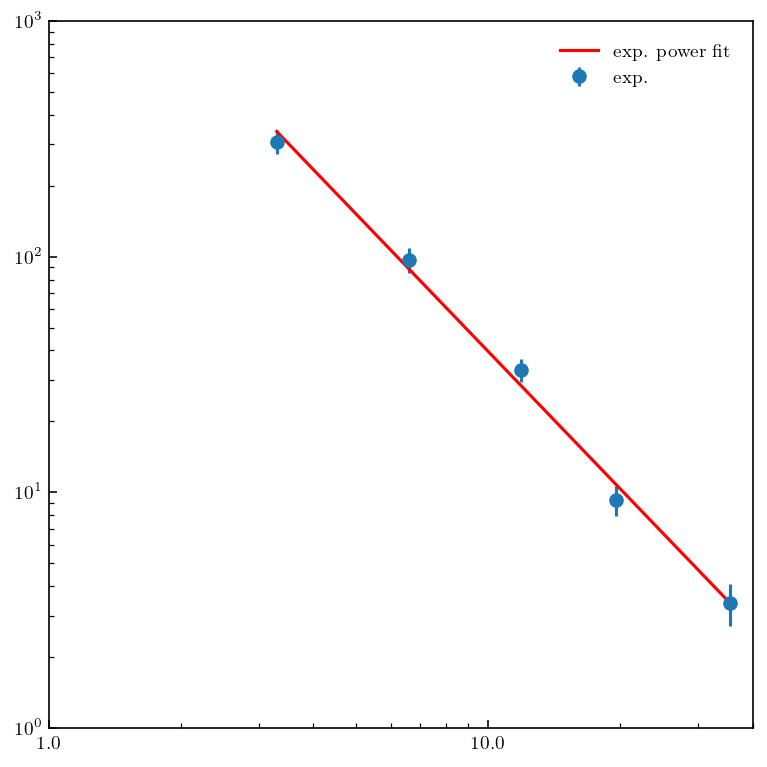

In [71]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
ax.errorbar(Q2points.df().Q2.values, Q2points.df().val.values, 
             yerr=Q2points.df().err.values, marker='o', linestyle='None', label='exp.')
fitsig = 10**parexp[0] * Q2points.df().Q2.values**(parexp[1])
ax.plot(Q2points.df().Q2.values, fitsig, 'r', label='exp. power fit')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 40)
ax.set_ylim(1, 1000)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.legend()
fig.canvas.draw()

This reproduces Fig. 6b in Favart et al. EPJA review. Note that choosing just longitudinal
component of cross section results in $Q$ to the power of -3.8, so is not that much flatter than total cross section.